In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from scipy import interp
import re
import string
from collections import Counter
from pandas.io.json import json_normalize
import dask.bag as db
import json
import h5py
import warnings # Turn off warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler, label_binarize, normalize
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.metrics import f1_score, auc, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingRegressor
from mlxtend.classifier import StackingClassifier
from sklearn.decomposition import NMF
from sklearn.base import BaseEstimator, TransformerMixin

# Logistic regression works the best
# GaussianNB, DecisionTree, and RandomForest are poor
# SVC and XGBoost will crash

In [4]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
    
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

In [3]:
def flatten_review(bag):
    """
    Columns in review.json: 'review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny', 'cool', 'text', 'date'
    """
    return {
        'date': bag['date'],
        'business_id': bag['business_id'],
        'useful': bag['useful'],
        'funny': bag['funny'],
        'cool': bag['cool'],
        'text': bag['text'],
        'stars': bag['stars']
    }



def flatten_business(bag):
    """
    Columns in review.json:
    'business_id', 'link_id', 'name',
    'address', 'city','state', 'postal_code', 'telephone', 'latitude',  'longitude',
    'stars', 'review_count', 'is_open',
    'attributes', 'categories', 'hours'
    """
    return {
        'business_id': bag['business_id'],
        'link_id': bag['link_id'],
        'name': bag['name'],
        'stars': bag['stars'],
        'review_count': bag['review_count'],
        'attributes': bag['attributes'],
        'categories': bag['categories'],
        'hours': bag['hours']
    }



def plot_heat_map(data_df):
    global ax
    plt.figure(figsize=(8, 5), dpi = 240)
    sns.heatmap(data_df.corr(), cmap= 'coolwarm', annot=False)
    ax = plt.axes()

    
    
def multiclass_confusion_matrix(y_test, y_predict):
    confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap='Blues', annot=True, square=True, fmt='d',
           xticklabels=['1', '2', '3', '4', '5'],
           yticklabels=['1', '2', '3', '4', '5']);
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title('Confusion Matrix', fontsize=16);
    #plt.savefig("Figures/Heatmap.png", transparent=False, bbox_inches="tight")
    
    
    
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
    
    
def compute_multiclass_ROC(y_test, y_score):
    """
    Takes "y_test" and "y_score" as inputs and returns the fpr, tpr, and roc_auc scores dictionary.
    
    Taken from scikit-learn's plot_roc tutorial. See below:
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    """
    
    fpr, tpr, thresholds, roc_auc = dict(), dict(), dict(), dict()
    
    # Compute micro-average ROC curve and ROC AUC
    for i in range(5):
        fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = roc_auc_score(y_test[:,i], y_score[:,i])

    # Collect results
    fpr["micro"], tpr["micro"], thresholds["micro"] = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(5)])) # Aggregate all false positive rates

    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(5):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= 5 # Average it

    # Collect Results
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    return fpr, tpr, thresholds, roc_auc

# Import Data

In [5]:
# Load JSON Data
review_full_bag = db.read_text("data/climbing-gym-reviews.json").map(json.loads) # Loads the json file as a dask bag
review_tuple = review_full_bag.take(10000) # Takes the first 10000 entries of the dask bag and stores as a tuple
review_bag = db.from_sequence(review_tuple, npartitions=1) # Converts back to bag for flattening
review_selected_tuple = review_bag.map(flatten_review).take(10000) # Grab important features
review_selected_df = json_normalize(list(review_selected_tuple)) # Convert tuple to dataframe

# Convert date to datetime object
review_selected_df.date = review_selected_df.date.apply(lambda x : dt.datetime.strptime(x, "%m/%d/%Y")) # Convert to datetime object

# Add text_length column
review_selected_df['text_length'] = review_selected_df['text'].apply(len)

# Clean Text
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
review_selected_df['text_clean'] = review_selected_df.text.map(alphanumeric).map(punc_lower)

review_selected_df.head() # Display filtered dataframe

,business_id,cool,date,funny,stars,text,useful,text_length,text_clean
0,3J-Q42JoMUPqRHfUckA2bw,0,2018-12-22,0,5,So far I like this place. The coaches are awes...,0,287,so far i like this place the coaches are awes...
1,3J-Q42JoMUPqRHfUckA2bw,0,2019-05-21,0,5,We love this place! You are greeted by staff w...,0,529,we love this place you are greeted by staff w...
2,3J-Q42JoMUPqRHfUckA2bw,1,2018-10-02,0,4,Had a nice climb here! I don't go climbing oft...,0,460,had a nice climb here i don t go climbing oft...
3,3J-Q42JoMUPqRHfUckA2bw,0,2019-04-19,0,5,This place is great. It's like walking into t...,0,409,this place is great it s like walking into t...
4,3J-Q42JoMUPqRHfUckA2bw,0,2019-03-29,0,5,I had never rock climbed and came with a frien...,0,706,i had never rock climbed and came with a frien...


In [6]:
# Load JSON Data
business_full_bag = db.read_text("data/climbing-gym-business.json").map(json.loads) # Loads the json file as a dask bag
business_tuple = business_full_bag.take(10000) # Takes the first 10000 entries of the dask bag and stores as a tuple
business_bag = db.from_sequence(business_tuple, npartitions=1) # Converts back to bag for flattening
business_selected_tuple = business_bag.map(flatten_business).take(10000) # Take turns it into a tuple
business_selected_df = json_normalize(list(business_selected_tuple)) # Convert tuple to dataframe

# Some preprocessing
business_selected_df.columns = business_selected_df.columns.str.replace('attributes.', '')
business_selected_df.columns = business_selected_df.columns.str.replace('hours.', '')
business_selected_df = business_selected_df.rename(columns = {'stars': 'avg_stars'}) # Prevent conflict with review_df
business_selected_df = business_selected_df.fillna(value = 0)
business_selected_df = business_selected_df.replace(to_replace=['Yes', 'No'], value=[1, 0])
business_selected_df

business_selected_df.head() # Display filtered dataframe

,attributes,Accepts Apple Pay,Accepts Credit Cards,Accepts Cryptocurrency,Accepts Google Pay,Bike Parking,Cannabis Products,Dogs Allowed,Good for Kids,Offers Military Discount,...,Mon,Sat,Sun,Thu,Tue,Wed,link_id,name,review_count,avg_stars
0,0.0,0,1,0,0,1,0,0,1,0,...,12:00 pm - 11:00 pm,10:00 am - 10:00 pm,10:00 am - 6:00 pm,12:00 pm - 11:00 pm,12:00 pm - 11:00 pm,12:00 pm - 11:00 pm,aesthetic-climbing-gym-lake-forest,Aesthetic Climbing Gym,66,4.5
1,0.0,0,1,0,0,1,0,0,1,0,...,6:00 am - 11:00 pm,8:00 am - 8:00 pm,8:00 am - 8:00 pm,6:00 am - 11:00 pm,6:00 am - 11:00 pm,6:00 am - 11:00 pm,berkeley-ironworks-climbing-and-fitness-club-b...,Berkeley Ironworks Climbing & Fitness Club,310,4.0
2,0.0,0,0,0,0,0,0,0,0,0,...,6:00 am - 10:00 pm,9:00 am - 10:00 pm,9:00 am - 10:00 pm,6:00 am - 10:00 pm,6:00 am - 10:00 pm,6:00 am - 10:00 pm,blue-granite-climbing-gym-south-lake-tahoe,Blue Granite Climbing Gym,9,5.0
3,0.0,0,1,0,0,1,0,0,1,0,...,11:00 am - 10:00 pm,10:00 am - 8:00 pm,10:00 am - 6:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,boulderdash-indoor-rock-climbing-thousand-oaks,Boulderdash Indoor Rock Climbing,99,4.0
4,0.0,0,0,0,0,1,0,0,1,0,...,11:00 am - 10:00 pm,10:00 am - 8:00 pm,10:00 am - 6:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,11:00 am - 10:00 pm,boulderdash-sfv-chatsworth-6,Boulderdash SFV,60,4.5


In [7]:
# Merge data
business_review_df = pd.merge(business_selected_df, review_selected_df, on="business_id")

In [8]:
len(business_review_df)

8317

In [9]:
business_review_df.columns

Index(['attributes', 'Accepts Apple Pay', 'Accepts Credit Cards',
       'Accepts Cryptocurrency', 'Accepts Google Pay', 'Bike Parking',
       'Cannabis Products', 'Dogs Allowed', 'Good for Kids',
       'Offers Military Discount', 'Open to All', 'Parking',
       'Wheelchair Accessible', 'Wi-Fi', 'business_id', 'categories', 'hours',
       'Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed', 'link_id', 'name',
       'review_count', 'avg_stars', 'cool', 'date', 'funny', 'stars', 'text',
       'useful', 'text_length', 'text_clean'],
      dtype='object')

In [10]:
# Set aside 20% of data for out of sample validation, using date to filter

features_list = ['text_length','useful','review_count', 'Dogs Allowed', 'funny',
                 'Open to All', 'Accepts Credit Cards', 'cool',
                 'Bike Parking', 'Good for Kids', 'avg_stars', 'text_clean']

features_train_df = business_review_df[business_review_df['date'] <= dt.datetime(2017, 5, 28)][features_list]
features_test_df = business_review_df[business_review_df['date'] > dt.datetime(2017, 5, 28)][features_list]
target_train_ser = business_review_df[business_review_df['date'] <= dt.datetime(2017, 5, 28)]['stars']
target_test_ser = business_review_df[business_review_df['date'] > dt.datetime(2017, 5, 28)]['stars']

# Binarize output
target_train_bin_array = label_binarize(target_train_ser, classes= [1, 2, 3, 4, 5])
target_test_bin_array = label_binarize(target_test_ser, classes = [1, 2, 3, 4, 5])

# Logistic Regresssion on Text Only

In [11]:
# Preprocessing steps

# Count Vectorizer
count_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3)) #ngram_range=(1,3)
features_train_vectorized_csr = count_vectorizer.fit_transform(features_train_df['text_clean']) # csr
features_test_vectorized_csr = count_vectorizer.transform(features_test_df['text_clean'])

# Tfidf
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,3), stop_words='english')
#features_train_vectorized = tfidf_vectorizer.fit_transform(features_train_ser)
#features_test_vectorized = tfidf_vectorizer.transform(features_test_ser)

In [12]:
# Initialize model
logreg_mlt_clf = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')

# Train the first model
logreg_mlt_clf.fit(features_train_vectorized_csr, target_train_ser)
features_train_vectorized_predict_array = logreg_mlt_clf.predict(features_train_vectorized_csr) # Needed for confusion matrix
features_train_vectorized_proba_array = logreg_mlt_clf.predict_proba(features_train_vectorized_csr)

# New Thresholds
count_dict = Counter(target_train_ser)
threshold_array = np.array([1/count_dict[1], 2.5/count_dict[2], 3/count_dict[3], 1/count_dict[4], 1/count_dict[5]])
features_train_vectorized_proba_array_new = normalize(features_train_vectorized_proba_array * threshold_array, axis=1, norm='l1')
features_train_vectorized_predict_array_new = np.argmax(features_train_vectorized_proba_array_new, axis=1)+1 # Needed for confusion matrix

# Compute Multiclass ROC for training set
fpr, tpr, thresholds, roc_auc = compute_multiclass_ROC(target_train_bin_array, features_train_vectorized_proba_array_new)
print("Unweighted Training Accuracy Score: ", f1_score(target_train_ser, features_train_vectorized_predict_array, average = "micro"))
print("Reweighted Training Accuracy Score: ", f1_score(target_train_ser, features_train_vectorized_predict_array_new, average = "micro"))

# Test
features_test_vectorized_predict_array = logreg_mlt_clf.predict(features_test_vectorized_csr) # Needed for confusion matrix
features_test_vectorized_proba_array = logreg_mlt_clf.predict_proba(features_test_vectorized_csr)

# New Thresholds
features_test_vectorized_proba_array_new = normalize(features_test_vectorized_proba_array * threshold_array, axis=1, norm='l1')
features_test_vectorized_predict_array_new = np.argmax(features_test_vectorized_proba_array_new, axis=1)+1 # Needed for confusion matrix

# Compute Multiclass ROC
fpr, tpr, thresholds, roc_auc = compute_multiclass_ROC(target_test_bin_array, features_test_vectorized_proba_array_new)
print("Unweighted Test Accuracy Score: ", f1_score(target_test_ser, features_test_vectorized_predict_array, average = "micro"))
print("Reweighted Test Accuracy Score: ", f1_score(target_test_ser, features_test_vectorized_predict_array_new, average = "micro"))

Unweighted Training Accuracy Score:  0.9998473748473748
Reweighted Training Accuracy Score:  0.9996947496947497
Unweighted Test Accuracy Score:  0.6651558073654391
Reweighted Test Accuracy Score:  0.635127478753541


In [13]:
# Un-weighted accuracy
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
print(confusion.trace()/confusion.sum())

# Re-weighted accuracy
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
print(confusion.trace()/confusion.sum())

# Un-weighted accuracy to within +/- 1 class, 
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')
print(sum([confusion_normalized_array[1:, :-1].trace()/5, confusion_normalized_array.trace()/5, confusion_normalized_array[:-1, 1:].trace()/5]))

# Re-weighted accuracy to within +/- 1 class
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')
print(sum([confusion_normalized_array[1:, :-1].trace()/5, confusion_normalized_array.trace()/5, confusion_normalized_array[:-1, 1:].trace()/5]))

0.6651558073654391
0.635127478753541
0.6866352509102764
0.8668862523003764


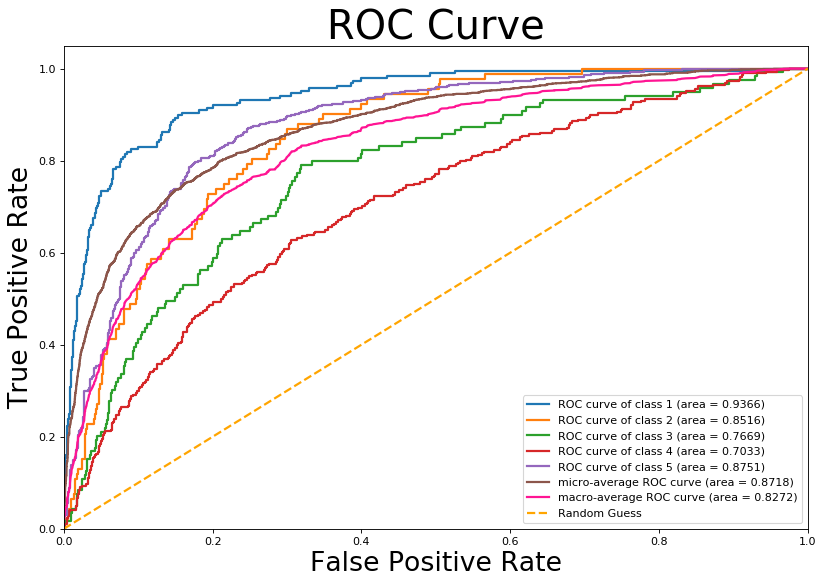

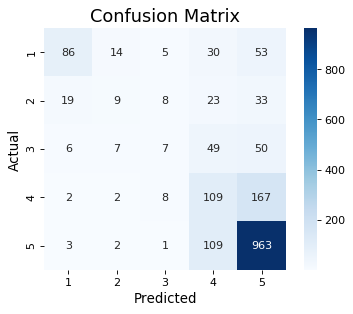

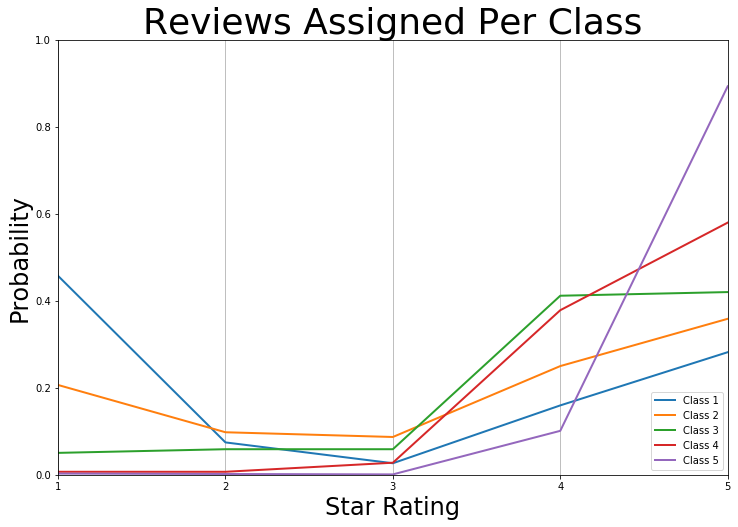

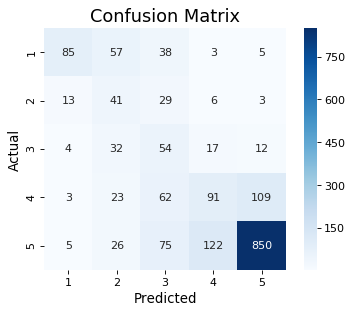

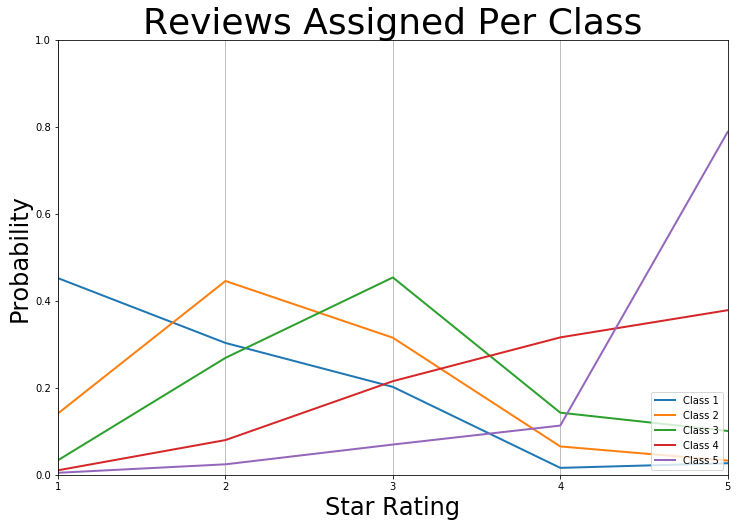

In [14]:
# Plot Micro-ROC curve for Weighted Test set
plt.figure(figsize=(12, 8), dpi=80)
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:1.4f})'.format(i+1, roc_auc[i]), lw=2)
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]), lw=2)
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]), color='deeppink', lw=2)
plt.plot([0, 1], [0, 1], c='orange', lw = 2, ls='--', label= "Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.title('ROC Curve', fontsize=36)
plt.legend(loc="lower right")
#plt.savefig("Figures/ROC 1.png", transparent=False, bbox_inches="tight")



# Unweighted

# Plot Multiclass Confusion Matrix
multiclass_confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
#plt.savefig("Figures/Confusion 2.png", transparent=False, bbox_inches="tight")

# Plot Probability Distribution for Each Class
star_list = [1, 2, 3, 4, 5]
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(5):
    ax.plot(star_list, confusion_normalized_array[i], label='Class {0}'.format(i+1), lw=2)
ax.set_xlabel('Star Rating', fontsize=24)
ax.set_xlim(left = 1, right = 5)
ax.set_xticks(star_list)
ax.set_ylim(bottom = 0, top = 1)
ax.set_ylabel('Probability', fontsize=24)
plt.legend(loc="lower right")
ax.set_title('Reviews Assigned Per Class', fontsize=36)
ax.xaxis.grid(True)
#plt.savefig("Figures/Class Predictions 2.png", transparent=False, bbox_inches="tight")



# Reweighted

# Plot Multiclass Confusion Matrix
multiclass_confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
#plt.savefig("Figures/Confusion 1.png", transparent=False, bbox_inches="tight")

# Plot Probability Distribution for Each Class
star_list = [1, 2, 3, 4, 5]
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(5):
    ax.plot(star_list, confusion_normalized_array[i], label='Class {0}'.format(i+1), lw=2)
ax.set_xlabel('Star Rating', fontsize=24)
ax.set_xlim(left = 1, right = 5)
ax.set_xticks(star_list)
ax.set_ylim(bottom = 0, top = 1)
ax.set_ylabel('Probability', fontsize=24)
plt.legend(loc="lower right")
ax.set_title('Reviews Assigned Per Class', fontsize=36)
ax.xaxis.grid(True)
#plt.savefig("Figures/Class Predictions 2.png", transparent=False, bbox_inches="tight")

# Include Categorical Features

In [17]:
# Build the pipeline

count = Pipeline([('selector', TextSelector(key='text_clean')),
    ('count_vectorizer', CountVectorizer(stop_words='english', ngram_range=(1,3)))])
tfidf = Pipeline([('selector', TextSelector(key='text_clean')),
    ('tfidf_vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1,3)))])
text_length = Pipeline([('selector', NumberSelector(key='text_length')),
    ('scaler', StandardScaler())])
useful = Pipeline([('selector', NumberSelector(key='useful')),
    ('scaler', StandardScaler())])
review_count = Pipeline([('selector', NumberSelector(key='review_count')),
    ('scaler', StandardScaler())])
dogs_allowed = Pipeline([('selector', NumberSelector(key='Dogs Allowed')),
    ('scaler', StandardScaler())])
funny = Pipeline([('selector', NumberSelector(key='funny')),
    ('scaler', StandardScaler())])
open_to_all = Pipeline([('selector', NumberSelector(key='Open to All')),
    ('scaler', StandardScaler())])
accepts_credit_cards = Pipeline([('selector', NumberSelector(key='Accepts Credit Cards')),
    ('scaler', StandardScaler())])
cool = Pipeline([('selector', NumberSelector(key='cool')),
    ('scaler', StandardScaler())])
bike_parking = Pipeline([('selector', NumberSelector(key='Bike Parking')),
    ('scaler', StandardScaler())])
good_for_kids = Pipeline([('selector', NumberSelector(key='Good for Kids')),
    ('scaler', StandardScaler())])
avg_stars = Pipeline([('selector', NumberSelector(key='avg_stars')),
    ('scaler', StandardScaler())])

feats = FeatureUnion([('count', count), 
                      ('tfidf', tfidf), 
                      ('text_length', text_length),
                      ('useful', useful),
                      ('review_count', review_count),
                      ('Dogs Allowed', dogs_allowed),
                      ('funny', funny),
                      ('Open to All', open_to_all),
                      ('Accepts Credit Cards', accepts_credit_cards),
                      ('cool', cool),
                      ('Bike Parking', bike_parking),
                      ('Good for Kids', good_for_kids), 
                      ('avg_stars', avg_stars)])

# Create the pipeline
pipeline = Pipeline([
    ('feats', feats),
    ('logreg_mlt_pipe clf', LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')),
])

In [18]:
# Process the features
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(features_train_df)

# Fit, takes a while
pipeline.fit(features_train_df, target_train_ser)

Pipeline(memory=None,
     steps=[('feats', FeatureUnion(n_jobs=None,
       transformer_list=[('count', Pipeline(memory=None,
     steps=[('selector', TextSelector(key='text_clean')), ('count_vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-...ty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False))])

In [19]:
# Training Scores
features_train_vectorized_predict_array = pipeline.predict(features_train_df) # Needed for confusion matrix
features_train_vectorized_proba_array = pipeline.predict_proba(features_train_df)

# New Thresholds
count_dict = Counter(target_train_ser)
threshold_array = np.array([1/count_dict[1], 2.5/count_dict[2], 3/count_dict[3], 1/count_dict[4], 1/count_dict[5]])
features_train_vectorized_proba_array_new = normalize(features_train_vectorized_proba_array * threshold_array, axis=1, norm='l1')
features_train_vectorized_predict_array_new = np.argmax(features_train_vectorized_proba_array_new, axis=1)+1 # Needed for confusion matrix

# Compute Multiclass ROC for training set
fpr, tpr, thresholds, roc_auc = compute_multiclass_ROC(target_train_bin_array, features_train_vectorized_proba_array_new)
print("Unweighted Training Accuracy Score: ", f1_score(target_train_ser, features_train_vectorized_predict_array, average = "micro"))
print("Reweighted Training Accuracy Score: ", f1_score(target_train_ser, features_train_vectorized_predict_array_new, average = "micro"))

features_test_vectorized_predict_array = pipeline.predict(features_test_df) # Needed for confusion matrix
features_test_vectorized_proba_array = pipeline.predict_proba(features_test_df)

# Test Scores
features_test_vectorized_proba_array_new = normalize(features_test_vectorized_proba_array * threshold_array, axis=1, norm='l1')
features_test_vectorized_predict_array_new = np.argmax(features_test_vectorized_proba_array_new, axis=1)+1 # Needed for confusion matrix

# Compute Multiclass ROC
fpr, tpr, thresholds, roc_auc = compute_multiclass_ROC(target_test_bin_array, features_test_vectorized_proba_array_new)
print("Unweighted Test Accuracy Score: ", f1_score(target_test_ser, features_test_vectorized_predict_array, average = "micro"))
print("Reweighted Test Accuracy Score: ", f1_score(target_test_ser, features_test_vectorized_predict_array_new, average = "micro"))

Unweighted Training Accuracy Score:  0.9996947496947497
Reweighted Training Accuracy Score:  0.9996947496947497
Unweighted Test Accuracy Score:  0.6764872521246459
Reweighted Test Accuracy Score:  0.6385269121813031


In [20]:
# Un-weighted accuracy
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
print(confusion.trace()/confusion.sum())

# Re-weighted accuracy
# This is actually better than before, but only very slightly
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
print(confusion.trace()/confusion.sum())

# Un-weighted accuracy to within +/- 1 class, 
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')
print(sum([confusion_normalized_array[1:, :-1].trace()/5, confusion_normalized_array.trace()/5, confusion_normalized_array[:-1, 1:].trace()/5]))

# Re-weighted accuracy to within +/- 1 class
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')
print(sum([confusion_normalized_array[1:, :-1].trace()/5, confusion_normalized_array.trace()/5, confusion_normalized_array[:-1, 1:].trace()/5]))

0.6764872521246459
0.6385269121813031
0.6907512934391933
0.8620288824889977


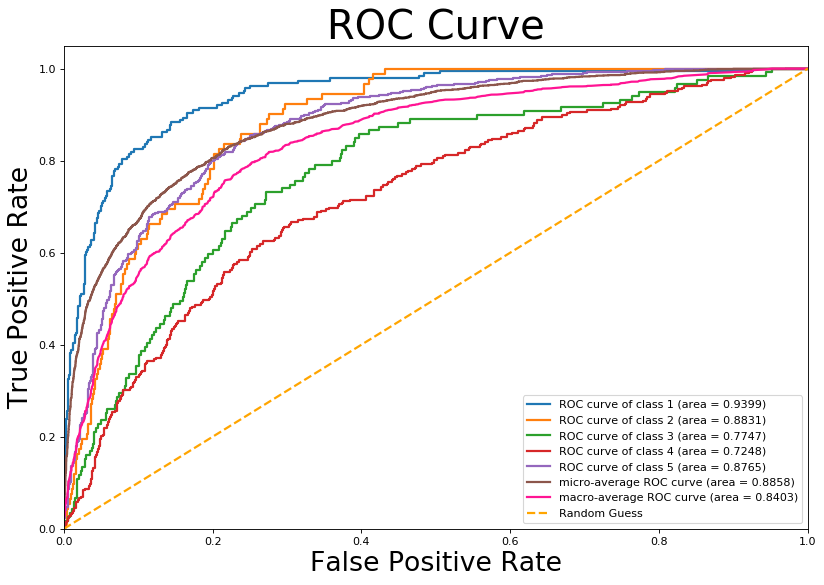

In [21]:
# Plot Micro-ROC curve for Weighted Test set
plt.figure(figsize=(12, 8), dpi=80)
for i in range(5):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:1.4f})'.format(i+1, roc_auc[i]), lw=2)
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = {0:0.4f})'.format(roc_auc["micro"]), lw=2)
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = {0:0.4f})'.format(roc_auc["macro"]), color='deeppink', lw=2)
plt.plot([0, 1], [0, 1], c='orange', lw = 2, ls='--', label= "Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.title('ROC Curve', fontsize=36)
plt.legend(loc="lower right")
#plt.savefig("Figures/ROC 1.png", transparent=False, bbox_inches="tight")

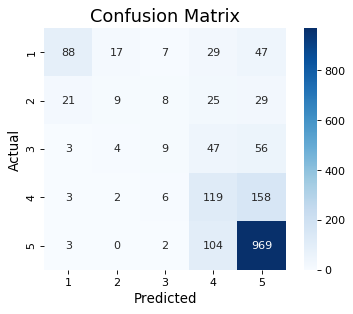

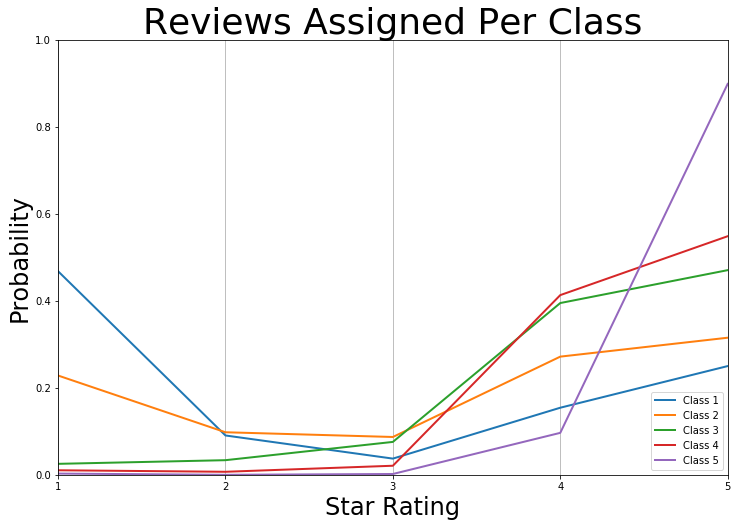

In [22]:
# Unweighted

# Plot Multiclass Confusion Matrix
multiclass_confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
#plt.savefig("Figures/Confusion 2.png", transparent=False, bbox_inches="tight")

# Plot Probability Distribution for Each Class
star_list = [1, 2, 3, 4, 5]
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(5):
    ax.plot(star_list, confusion_normalized_array[i], label='Class {0}'.format(i+1), lw=2)
ax.set_xlabel('Star Rating', fontsize=24)
ax.set_xlim(left = 1, right = 5)
ax.set_xticks(star_list)
ax.set_ylim(bottom = 0, top = 1)
ax.set_ylabel('Probability', fontsize=24)
plt.legend(loc="lower right")
ax.set_title('Reviews Assigned Per Class', fontsize=36)
ax.xaxis.grid(True)
#plt.savefig("Figures/Class Predictions 2.png", transparent=False, bbox_inches="tight")

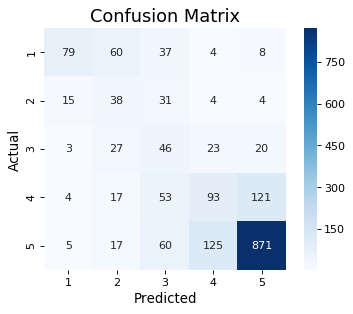

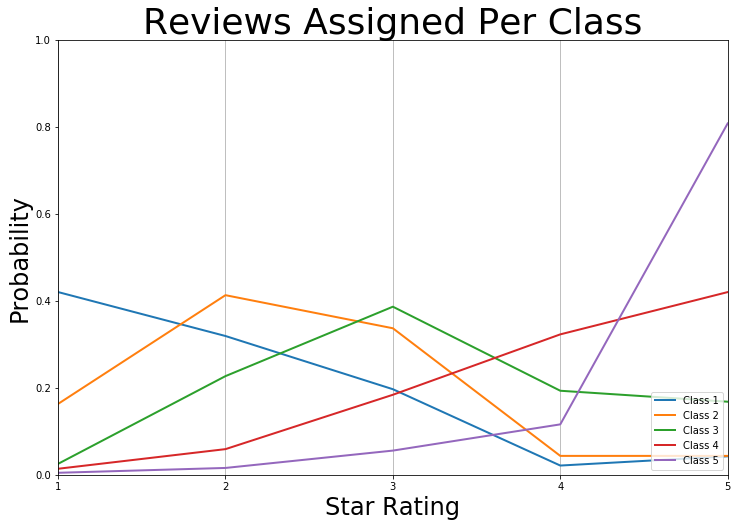

In [23]:
# Reweighted

# Plot Multiclass Confusion Matrix
multiclass_confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
#plt.savefig("Figures/Confusion 1.png", transparent=False, bbox_inches="tight")

# Plot Probability Distribution for Each Class
star_list = [1, 2, 3, 4, 5]
confusion = confusion_matrix(target_test_ser, features_test_vectorized_predict_array_new)
confusion_normalized_array = normalize(confusion, axis=1, norm='l1')

fig, ax = plt.subplots(figsize=(12, 8))
for i in range(5):
    ax.plot(star_list, confusion_normalized_array[i], label='Class {0}'.format(i+1), lw=2)
ax.set_xlabel('Star Rating', fontsize=24)
ax.set_xlim(left = 1, right = 5)
ax.set_xticks(star_list)
ax.set_ylim(bottom = 0, top = 1)
ax.set_ylabel('Probability', fontsize=24)
plt.legend(loc="lower right")
ax.set_title('Reviews Assigned Per Class', fontsize=36)
ax.xaxis.grid(True)
#plt.savefig("Figures/Class Predictions 2.png", transparent=False, bbox_inches="tight")